In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from os import path,listdir
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
CURRENT_DIR = path.abspath(path.curdir)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Linear(4,16)
        self.layer2 = nn.Linear(16,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,2)


    def forward(self,x):
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        
        return x 

In [11]:
class Agent():
    def __init__(self,device,minmem,maxmem):
        self.env = gym.make("CartPole-v1")
        self.device = device
        self.net = Net().to(self.device)
        self.target = Net().to(self.device)
        self.target.load_state_dict(self.net.state_dict())
        self.maxmem = maxmem
        self.minmem = minmem
        self.memory = deque([], maxlen=self.maxmem)
        self.epsilon = 1
        self.decay = 0.995
        self.gamma = 0.95
        self.optim = torch.optim.Adam(self.net.parameters(),lr=0.01)
        self.scores = []
        self.means = []
        self.losses = []
        
    def predict(self,observation):
        return self.net(observation)
    
    
    def train(self,epochs,num_games,batch_size):
        
        e = 0
        
        while e<epochs:

            self.scores = []
            
            
            
            for _ in range(num_games):

                done = False
                observation = self.env.reset()
                trainexamples = []
                session_score = 0

                while not done:

                    nnet_input = torch.tensor(observation).float()

                    with torch.no_grad():

                        prediction = self.predict(nnet_input.to(self.device)).cpu()


                    if np.random.uniform(0,1)>self.epsilon:
                        action = 1 if prediction[1]>=prediction[0] else 0
                    else:
                        action = np.random.randint(0,2)

                    session_score += 1

                    observation, reward, done, info = self.env.step(action)
                    
                    next_state = torch.tensor(observation).float()

                    
                    trainexamples.append([nnet_input,action,-100 if done and session_score<500 else 1,next_state])

                current_reward = 0
                for example in reversed(trainexamples):
                    current_reward = example[2] + self.gamma*current_reward
                    self.memory.append([example[0][0],example[0][1],example[0][2],example[0][3],torch.tensor(example[1]),torch.tensor(current_reward)])

#                 for example in reversed(trainexamples):

#                     self.memory.append([example[0][0],example[0][1],example[0][2],example[0][3],torch.tensor(example[1]),torch.tensor(example[2]),example[3][0],example[3][1],example[3][2],example[3][3]])
 

                self.scores.append(session_score)
        
            
                
            
            mean = np.mean(self.scores[-num_games:])
            print(f'Epoch {e+1} mean score was {mean} over {len(self.scores)} games.')
            self.means.append(np.mean(self.scores))
           
 
            self.epsilon = max(0.05,self.decay*self.epsilon)
    
            if len(self.memory)>self.minmem:

                for _ in range(5):
                
                    self.optim.zero_grad()

                    data = torch.tensor(random.sample(self.memory,batch_size))
                    nnet_input = data[:,:4]
                    actions = data[:,4]
                    rewards = data[:,5]
#                     next_states = data[:,6:]
                    

                    outputs = self.predict(nnet_input.to(self.device)).cpu()
 

#                     with torch.no_grad():
#                         maxqs = torch.max(self.target(next_states.to(self.device)).cpu(),axis=1)[0]
            


                    targets = outputs.clone()

                    for i in range(targets.shape[0]):
                        targets[i,actions[i].numpy()] = rewards[i] #+ self.gamma*maxqs[i]

                    loss = torch.mean((outputs-targets)**2)
                    self.losses.append(loss.item())
                    loss.backward()
                    self.optim.step()
                    

                
            e += 1
            
            
#             thetas = []
#             omegas = []
#             choices = []

#             for i in np.arange(-1,1,0.01):
#                 for j in np.arange(-10,10,0.1):
#                     nnet_input = torch.tensor((0,0,i,j))
#                     with torch.no_grad():
#                         output = self.net(nnet_input.cuda()).cpu()
#                     thetas.append(i)
#                     omegas.append(j)
#                     choices.append(np.argmax(output).item())
                    
#             arr1 = np.array(thetas)
#             arr2 = np.array(omegas)
#             arr3 = np.array(choices)
            
#             plt.scatter(arr1[np.where(arr3==0)],arr2[np.where(arr3==0)],c="blue")
#             plt.scatter(arr1[np.where(arr3==1)],arr2[np.where(arr3==1)],c="red")
#             plt.title("Neural Network Decision Boundary")
#             plt.xlim([-0.1,0.1])
#             plt.ylim([-1,1])
#             plt.xlabel("Pole Angle")
#             plt.ylabel("Pole Angular Velocity")
#             plt.savefig(f'Tracking Net/snapshot {e}.png')
#             plt.clf()
                    
                    
#             torch.save(self.net.state_dict(),f'./models/versions/dqn_{e}')
            if e+1%10==0:
                torch.save(self.net.state_dict(),'./models/dqn')
                self.target.load_state_dict(self.net.state_dict())  

#             print(f'Epoch {e} completed')

In [73]:
# torch.save(agent.net.state_dict(),'./models/random_dqn')

In [17]:
agent = Agent(DEVICE,minmem=10000,maxmem=100000)

In [ ]:
agent.train(epochs=1000,num_games=100,batch_size=1024)

Epoch 1 mean score was 21.57 over 100 games.
Epoch 2 mean score was 23.71 over 100 games.
Epoch 3 mean score was 23.54 over 100 games.
Epoch 4 mean score was 23.32 over 100 games.
Epoch 5 mean score was 21.5 over 100 games.
Epoch 6 mean score was 21.01 over 100 games.
Epoch 7 mean score was 21.49 over 100 games.
Epoch 8 mean score was 25.13 over 100 games.
Epoch 9 mean score was 21.42 over 100 games.
Epoch 10 mean score was 21.65 over 100 games.
Epoch 11 mean score was 21.42 over 100 games.
Epoch 12 mean score was 20.62 over 100 games.
Epoch 13 mean score was 24.06 over 100 games.
Epoch 14 mean score was 22.25 over 100 games.
Epoch 15 mean score was 23.82 over 100 games.
Epoch 16 mean score was 21.57 over 100 games.
Epoch 17 mean score was 22.19 over 100 games.
Epoch 18 mean score was 20.13 over 100 games.
Epoch 19 mean score was 23.45 over 100 games.
Epoch 20 mean score was 21.08 over 100 games.
Epoch 21 mean score was 22.01 over 100 games.
Epoch 22 mean score was 20.86 over 100 games

Epoch 177 mean score was 227.0 over 100 games.
Epoch 178 mean score was 210.99 over 100 games.
Epoch 179 mean score was 220.27 over 100 games.
Epoch 180 mean score was 174.79 over 100 games.
Epoch 181 mean score was 206.52 over 100 games.
Epoch 182 mean score was 223.44 over 100 games.
Epoch 183 mean score was 216.77 over 100 games.
Epoch 184 mean score was 231.36 over 100 games.
Epoch 185 mean score was 225.91 over 100 games.
Epoch 186 mean score was 224.23 over 100 games.
Epoch 187 mean score was 227.47 over 100 games.
Epoch 188 mean score was 224.67 over 100 games.
Epoch 189 mean score was 196.69 over 100 games.
Epoch 190 mean score was 193.84 over 100 games.
Epoch 191 mean score was 225.83 over 100 games.
Epoch 192 mean score was 223.73 over 100 games.
Epoch 193 mean score was 235.5 over 100 games.
Epoch 194 mean score was 206.3 over 100 games.
Epoch 195 mean score was 182.27 over 100 games.
Epoch 196 mean score was 211.2 over 100 games.
Epoch 197 mean score was 249.99 over 100 gam

In [26]:
agent.epsilon

0.09576389217857617

In [7]:
agent.memory

deque([[tensor(0.0910),
        tensor(1.1995),
        tensor(-0.1747),
        tensor(-1.9210),
        tensor(0),
        tensor(-100.)],
       [tensor(0.0710),
        tensor(1.0030),
        tensor(-0.1429),
        tensor(-1.5874),
        tensor(1),
        tensor(-98.5000)],
       [tensor(0.0548),
        tensor(0.8065),
        tensor(-0.1177),
        tensor(-1.2603),
        tensor(1),
        tensor(-97.0075)],
       [tensor(0.0348),
        tensor(1.0005),
        tensor(-0.0872),
        tensor(-1.5245),
        tensor(0),
        tensor(-95.5225)],
       [tensor(0.0187),
        tensor(0.8046),
        tensor(-0.0630),
        tensor(-1.2128),
        tensor(1),
        tensor(-94.0449)],
       [tensor(0.0066),
        tensor(0.6089),
        tensor(-0.0448),
        tensor(-0.9064),
        tensor(1),
        tensor(-92.5746)],
       [tensor(-0.0017),
        tensor(0.4134),
        tensor(-0.0328),
        tensor(-0.6035),
        tensor(1),
        tensor(-91.11

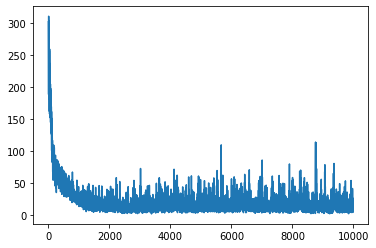

In [58]:
plt.plot(agent.losses);

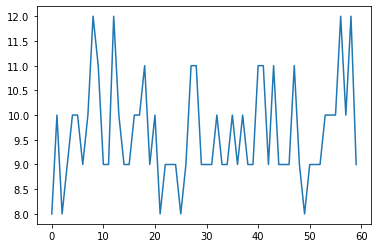

In [148]:
plt.plot(agent.scores);

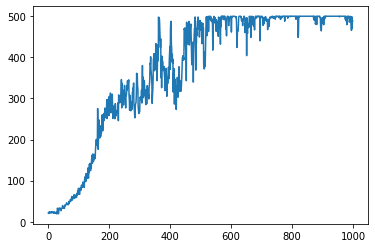

In [8]:
plt.plot(agent.means);

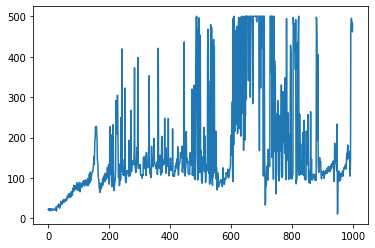

In [15]:
plt.plot(agent.means);

In [196]:
agent.epsilon

0.35608578229633

In [16]:
env = gym.make("CartPole-v1")

In [24]:
observation = env.reset()
nnet_input = torch.tensor(observation).float()
print(nnet_input)
with torch.no_grad():
    prediction = agent.predict(nnet_input.to(DEVICE)).cpu()
print(prediction)

tensor([ 0.0162, -0.0468,  0.0376,  0.0083])
tensor([-85.4893, -85.3934])


In [60]:

# for _ in range(50):
if True:
    observation = env.reset()
    done = False

    i = 0
    while not done:

#         env.render()
        nnet_input = torch.tensor(observation).float()

        with torch.no_grad():

            prediction = agent.predict(nnet_input.to(DEVICE)).cpu()

        print(observation)
        print(prediction)
        print('')

        action = np.argmax(prediction).item()

        observation, reward, done, info = env.step(action)

        i += 1

#     print(i)


[-0.01325967  0.00823835  0.01401963  0.01479182]
tensor([0.6590, 0.3380])

[-0.0130949  -0.18708182  0.01431546  0.31186493]
tensor([0.6577, 0.3413])

[-0.01683654 -0.38240476  0.02055276  0.60902792]
tensor([0.6565, 0.3443])

[-0.02448463 -0.57780791  0.03273332  0.90811282]
tensor([0.6555, 0.3469])

[-0.03604079 -0.77335732  0.05089558  1.21090168]
tensor([0.6551, 0.3420])

[-0.05150794 -0.96909808  0.07511361  1.51908947]
tensor([0.6551, 0.3362])

[-0.0708899  -1.16504353  0.1054954   1.83424153]
tensor([0.6551, 0.3362])

[-0.09419077 -1.36116249  0.14218023  2.15774264]
tensor([ 0.6067, -2.3603])

[-0.12141402 -1.55736423  0.18533508  2.49073585]
tensor([-100.4042, -100.8642])



In [9]:
means_random = pd.DataFrame({"means":agent.means})
means_random.to_csv(CURRENT_DIR + "/Results/means_randomnet.csv")

In [16]:
means_net = pd.DataFrame({"means":agent.means})
means_net.to_csv(CURRENT_DIR + "/Results/means_net.csv")

In [23]:
df.head()

,means
0,21.14
1,21.26
2,21.81
3,21.89
4,21.11


In [75]:
svmdf = pd.read_csv(CURRENT_DIR + "/Results/means_svm.csv")
randf = pd.read_csv(CURRENT_DIR + "/Results/means_randomnet.csv")
netdf = pd.read_csv(CURRENT_DIR + "/Results/means_net.csv")

In [39]:
means_random.to_csv(CURRENT_DIR + "/Results/means_randomnet.csv")

In [14]:
svmdf["0"].values

array([ 21,  14,  14, ..., 500, 500, 373], dtype=int64)

In [20]:
netdf

,Unnamed: 0,means
0,0,21.14
1,1,21.26
2,2,21.81
3,3,21.89
4,4,21.11
...,...,...
551,551,500.00
552,552,500.00
553,553,500.00
554,554,500.00


In [17]:
len(svmdf["0"].values)

1056181

In [18]:
scores = []
for i in range(len(svmdf["0"].values)):
    
    scores.append(np.mean(svmdf["0"].values[i*100:i*100+100]))

P:\Users\Owner\Anaconda3\envs\bigbrain\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
P:\Users\Owner\Anaconda3\envs\bigbrain\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


''

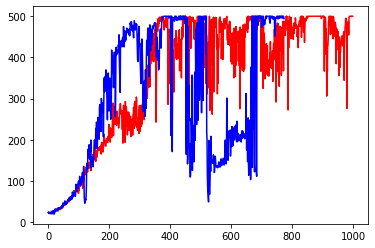

In [76]:
plt.plot(randf["means"].values,"red")
plt.plot(netdf["means"].values,"blue")
# plt.plot(svmdf["means"].values,"green")
;

In [24]:
df = pd.DataFrame({"means":scores})
df.to_csv(CURRENT_DIR + "/Results/means_svm.csv")

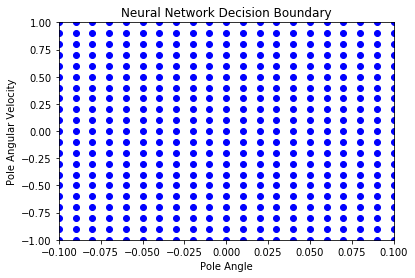

In [149]:
thetas = []
omegas = []
choices = []

for i in np.arange(-0.1,0.1,0.0005):
    for j in np.arange(-1,1,0.005):
        nnet_input = torch.tensor((0,0,i,j))
        with torch.no_grad():
            output = agent.net(nnet_input.cuda()).cpu()
        thetas.append(i)
        omegas.append(j)
        choices.append(np.argmax(output).item())

arr1 = np.array(thetas)
arr2 = np.array(omegas)
arr3 = np.array(choices)

plt.scatter(arr1[np.where(arr3==0)],arr2[np.where(arr3==0)],c="blue")
plt.scatter(arr1[np.where(arr3==1)],arr2[np.where(arr3==1)],c="red")
plt.title("Neural Network Decision Boundary")
plt.xlim([-0.1,0.1])
plt.ylim([-1,1])
plt.xlabel("Pole Angle")
plt.ylabel("Pole Angular Velocity")
plt.savefig(f'Tracking Net/snapshot 0.png')

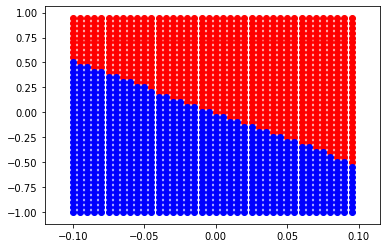

In [119]:
plt.scatter(test0[np.where(test2==1)],test1[np.where(test2==1)],c="red")
plt.scatter(test0[np.where(test2==0)],test1[np.where(test2==0)],c="blue");

In [100]:
test0 = np.array(thetas)
test1 = np.array(omegas)
test2 = np.array(choices)

In [103]:
len(test0[np.where(test2==1)])

776

In [104]:
len(test0)

1600

In [111]:
thetas[np.where(test2==1)[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [113]:
np.where(test2==1)[0]

array([  31,   32,   33,   34,   35,   36,   37,   38,   39,   70,   71,
         72,   73,   74,   75,   76,   77,   78,   79,  110,  111,  112,
        113,  114,  115,  116,  117,  118,  119,  149,  150,  151,  152,
        153,  154,  155,  156,  157,  158,  159,  189,  190,  191,  192,
        193,  194,  195,  196,  197,  198,  199,  228,  229,  230,  231,
        232,  233,  234,  235,  236,  237,  238,  239,  268,  269,  270,
        271,  272,  273,  274,  275,  276,  277,  278,  279,  307,  308,
        309,  310,  311,  312,  313,  314,  315,  316,  317,  318,  319,
        347,  348,  349,  350,  351,  352,  353,  354,  355,  356,  357,
        358,  359,  386,  387,  388,  389,  390,  391,  392,  393,  394,
        395,  396,  397,  398,  399,  426,  427,  428,  429,  430,  431,
        432,  433,  434,  435,  436,  437,  438,  439,  465,  466,  467,
        468,  469,  470,  471,  472,  473,  474,  475,  476,  477,  478,
        479,  504,  505,  506,  507,  508,  509,  5